# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, we will use the tools we learned about in the lesson to identify lane lines on the road. We will develop our pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output will look like after using the helper functions below. 

Once we have a result that looks roughly like "raw-lines-example.mp4", we'll need to get creative and try to average and/or extrapolate the line segments we've detected to map out the full extent of the lane lines.  There is an example of the result we're going for in the video "P1_example.mp4".  Ultimately, we will draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup in this file (file link)



**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

## 1. Import Packages

In [1]:
#importing required packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
%matplotlib inline

## 2. Defining Required functions

In [2]:
import math


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    mpimg.imread() uses RGB whereas cv2.imread() uses BGR"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img



def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## 3. Function definition for "Lines Extrapolation" 
***
Based on the idea presented in the template file and using basic line equations from geometry, we are extrapolating the lines. 

In [3]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    height, width = img.shape[:2]
    num_leftlines = 0
    num_RLines = 0
    x_left = 0 
    y_left = 0
    x_right = 0
    y_right = 0
    slope_leftlane = 0
    slope_rightlane = 0
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2 - y1) / (x2 - x1)
            #We are cheking for straight line.If detected is straight line we will discard
            if (x2 - x1) != 0: 
              #else if slope is positive and greater than 5 degree we are including that line to calculate our mid point of left lane.
                if m > 0.1 : 
                    slope_leftlane += m
                    x_left += (x1+x2)/2
                    y_left += (y1+y2)/2
                    num_leftlines += 1
                    
                elif m < -0.2 : #If the slope of line is negative and less than 169 and more than 91 degree we include that point in right lane
                    slope_rightlane += m
                    x_right += (x1+x2)/2
                    y_right += (y1+y2)/2
                    num_RLines += 1
                    
    
    #If there are any lines with slopes more than 5 degree detcted, we calculate the average of x y and slope.
    if num_leftlines > 0:
        x_left_mean = x_left / num_leftlines
        y_left_mean = y_left / num_leftlines
        slope_leftlane_mean = slope_leftlane / num_leftlines
        
     #Calculating extrapolated x coordinates on left lane
        Leftx_down_extrapolated = int(((int(height) - y_left_mean)/slope_leftlane_mean) + x_left_mean)
        Leftx_up_extrapolated    = int(((int(0.62*height) - y_left_mean)/slope_leftlane_mean) + x_left_mean)
        
    else: #If there are no left lines detected, assume some x_bottom and x_top
        Leftx_down_extrapolated = int(0.21 * width)
        Leftx_up_extrapolated    = int(0.43 * width)
        
        #Draw left line
    cv2.line(img, (Leftx_down_extrapolated, int(height)), (Leftx_up_extrapolated, int(0.62*height)), color, thickness)
    
    
    
    #If there are any lines with slopes negative and less than 169 and more than 91 degree detcted, we calculate the average of x y and slope.
    if num_RLines > 0:
        right_mp_mean_x = x_right / num_RLines
        right_mp_mean_y = y_right / num_RLines
        slope_rightlane_mean = slope_rightlane / num_RLines
        
        #Calculating extrapolated x coordinates on right lane
        Rightx_down_extrapolated = int(((int(height) - right_mp_mean_y)/slope_rightlane_mean) + right_mp_mean_x)
        Rightx_up_extrapolated   = int(((int(0.62*height) - right_mp_mean_y)/slope_rightlane_mean) + right_mp_mean_x)
        
    else: #If there are no right lines detected, assume some x_bottom and x_top
        Rightx_down_extrapolated = int(0.79 * width)
        Rightx_up_extrapolated   = int(0.57 * width)
        
        #Drawing right line
    cv2.line(img, (Rightx_down_extrapolated, int(height)), (Rightx_up_extrapolated, int(0.62*height)), color, thickness)

## 4. Define a Pipeline
***
Based on the above defined functions, we are building our pipeline

In [4]:
#Pipeline
def draw_lane_lines(Input_img, Input_img_name):
    
    #Define all the input parameters for functions which we are using in our pipeline 
    initial_img = np.copy(Input_img)
    height, width = initial_img.shape[:2]
    #Hyperparameters
    kernel_size = 5
    low_threshold = 50
    high_threshold = 150
    vertices = np.array([[(150,540),(470,313),(490,313),(880,540)]], dtype=np.int32)
    #Hough hyperparameters
    rho = 1
    theta = np.pi / 180
    threshold = 35 #no. of intersections of lines in Hough space
    min_line_len = 25
    max_line_gap = 50
    
    
    #convert to grey Image
    gray_Image = cv2.cvtColor(Input_img,cv2.COLOR_RGB2GRAY)
    
    #Apply Gaussian Blur
    Gblur_Image = cv2.GaussianBlur(gray_Image,(kernel_size, kernel_size), 0)
    
    #Apply canny edge detection
    Canny_Image = canny(Gblur_Image, low_threshold, high_threshold)
    
    #Define ROI
    ROI_Image = region_of_interest(Canny_Image, vertices)
    
    #Apply Hough transform
    Hough_lines = hough_lines(ROI_Image, rho, theta, threshold, min_line_len, max_line_gap)

    #Augumented Image
    Augumented_Image = weighted_img(Hough_lines, initial_img, α=0.8, β=1., γ=0.)
    

    
    return Augumented_Image

***
***
***

## **5. Lets explore each function step by step on a single image  ** 
***

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


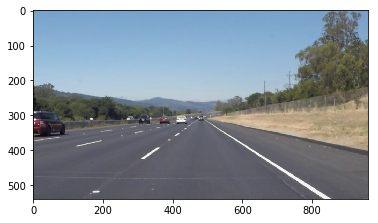

In [6]:
#reading in an image
original_image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(original_image), 'with dimensions:', original_image.shape)
plt.imshow(original_image)  

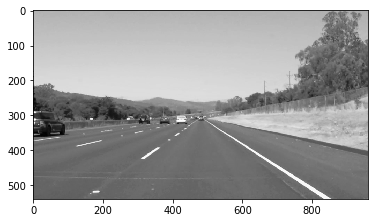

In [7]:
 
#first convert our original image to gray scale image
gray_Image = cv2.cvtColor(original_image,cv2.COLOR_RGB2GRAY)
plt.imshow(gray_Image, cmap='Greys_r')

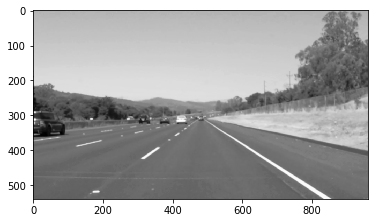

In [8]:
#Apply Gaussian Blur to the above gray Image
kernel_size = 5
Gblur_Image = cv2.GaussianBlur(gray_Image,(kernel_size, kernel_size), 0)
plt.imshow(Gblur_Image, cmap='Greys_r')

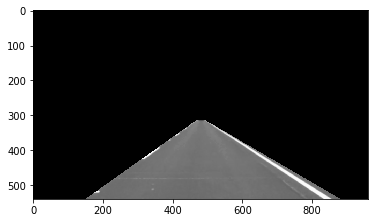

In [9]:
Img = Gblur_Image
vertices = np.array([[(150,540),(470,313),(490,313),(880,540) ]], dtype=np.int32)
ROI_Image = region_of_interest(Img, vertices)
plt.imshow(ROI_Image, cmap='Greys_r')

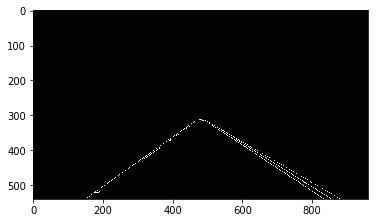

In [10]:
#Apply Uncanny edge detection filter
img = ROI_Image
low_threshold = 50
high_threshold = 150
Canny_Image = canny(img, low_threshold, high_threshold)
plt.imshow(Canny_Image, cmap='Greys_r')

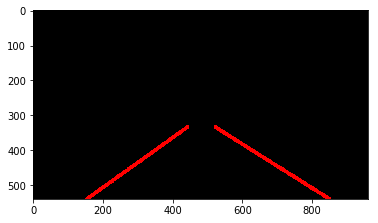

In [11]:
#Apply Hough transform to get an array of the coordinates of all possible lines
img = Canny_Image
rho = 1
theta = np.pi / 180
threshold = 35
min_line_len = 25
max_line_gap = 50
Hough_lines = hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
plt.imshow(Hough_lines)

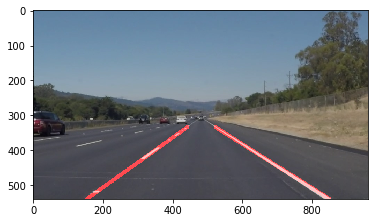

In [12]:
#Now overlap the Hough lines image to our original image 
initial_img = original_image
img = Hough_lines
Augumented_Image = weighted_img(img, initial_img, α=0.8, β=1., γ=0.)
plt.imshow(Augumented_Image)

***
***
***

## **6. Now apply the Pipeline function on all images in test folder ** 
***

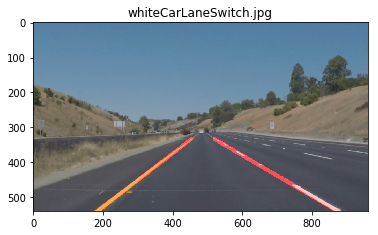

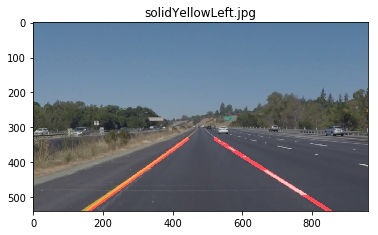

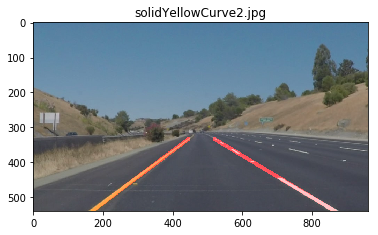

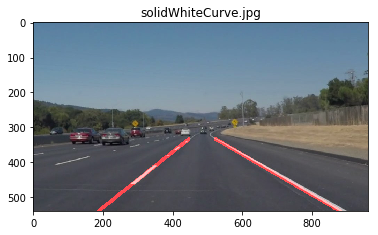

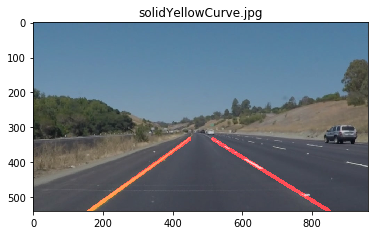

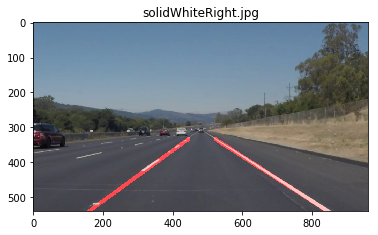

In [13]:
import os
images = os.listdir("test_images/")
for Input_Img in images:
    img_output = 'output_'+Input_Img
    #img_output = 'output_RGBvsBGR'+Input_Img
    ind_image = mpimg.imread("test_images/" + Input_Img)
    img_processed = draw_lane_lines(ind_image, Input_Img)
    plt.imshow(img_processed)
    plt.title(Input_Img)
    plt.show()
    cv2.imwrite("test_images_output/"+img_output, img_processed)

***
***
***

## **7. Detect Lanes in video file using our pipeline ** 
***

In [14]:
def process_image(image):
    """
    Please follow this link in stack overflow for understanding 
    https://stackoverflow.com/questions/40965423/how-to-use-fl-image-function-in-moviepy-within-python
    """
    result = draw_lane_lines(image,'video')
    return result

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'test_videos_output/solidWhiteRight_processed.mp4'
Input_video = VideoFileClip("test_videos/solidWhiteRight.mp4")
Processed = Input_video.fl_image(process_image)
%time Processed.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_processed.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_processed.mp4


100%|█████████▉| 221/222 [00:12<00:00, 17.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_processed.mp4 

CPU times: user 2.03 s, sys: 245 ms, total: 2.27 s
Wall time: 14.3 s


***
***
***

## **8. Challenge Accepted !!!!!!!!!** 
***

In [16]:
Challenge_video_output = 'test_videos_output/challenge_done.mp4'
input_video = VideoFileClip('test_videos/challenge.mp4')
Processed = input_video.fl_image(process_image)
%time Processed.write_videofile(Challenge_video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(Challenge_video_output))

[MoviePy] >>>> Building video test_videos_output/challenge_done.mp4
[MoviePy] Writing video test_videos_output/challenge_done.mp4


100%|██████████| 251/251 [00:30<00:00,  7.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_done.mp4 

CPU times: user 4.61 s, sys: 435 ms, total: 5.05 s
Wall time: 34.2 s
